In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import yaml
import logging
import uuid
from importlib import import_module


try:
    from .exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from .base_plugin import BasePlugin
except ImportError:
    # support jupyter developement
    from exceptions import PluginError, ImageError, PluginTimeoutError, FileError, ConfigurationError
    from base_plugin import BasePlugin

In [3]:
logger = logging.getLogger(__name__)

In [4]:
import sys
# Configure logging to show in Jupyter Notebook with detailed output
def setup_notebook_logging(level=logging.DEBUG):
    log_format = (
        '%(asctime)s [%(levelname)s] [%(name)s] '
        '[%(module)s.%(funcName)s] [%(lineno)d] - %(message)s'
    )
    
    # Clear any existing handlers to prevent duplicate logging
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    # Set up logging for notebook
    logging.basicConfig(
        level=level,
        format=log_format,
        handlers=[logging.StreamHandler(sys.stdout)]
    )
    
    logging.getLogger(__name__).debug("Notebook logging configured.")

# Run this cell to enable logging
setup_notebook_logging()

2024-12-31 17:03:04,384 [DEBUG] [__main__] [1754761213.setup_notebook_logging] [20] - Notebook logging configured.


In [5]:
setup_notebook_logging(logging.INFO)

In [177]:
class PluginManager:
    """
    Manages the loading, configuration, and lifecycle of plugins.

    This class handles plugin discovery, schema validation, dynamic loading,
    and execution of plugins. It supports active and dormant plugins, with the
    ability to update, remove, and reconfigure plugins at runtime.

    Attributes:
        plugin_path (Path): Path to the directory containing plugins.
        config_path (Path): Path to the configuration directory.
        max_plugin_failures (int): Maximum number of consecutive failures before a plugin is removed.
        foreground_plugin (BasePlugin): The currently active plugin being displayed.
    
    Example:
        manager = PluginManager(config=config, plugin_path=Path('./plugins'))
        manager.load_plugins()
        manager.update_plugins()
    """    
    # ----- Plugin Status Constants
    ACTIVE = 'active'
    DORMANT = 'dormant'
    LOAD_FAILED = 'load_failed'
    PENDING = 'pending_validation'
    
    # ----- Init
    def __init__(
        self,
        config: dict = None,
        plugin_path: Path = None,
        config_path: Path = None,
        main_schema_file: str = None,
        plugin_schema_file: str = None,
        max_plugin_failures: int = 5,
    ):
        """
        Initialize the PluginManager.

        Args:
            config (dict, optional): Initial configuration for the plugin manager.
            plugin_path (Path, optional): Path to the plugin directory.
            config_path (Path, optional): Path to the configuration directory.
            main_schema_file (str, optional): Main schema file for validating the config.
            plugin_schema_file (str, optional): Schema file for validating individual plugins.
            max_plugin_failures (int, optional): Number of allowed consecutive failures before a plugin is removed (default: 5).
        """
        self._config = {}
        self._configured_plugins = []
        self.active_plugins = []
        self.dormant_plugins = []
        self.plugin_path = plugin_path
        self.config_path = config_path
        self.main_schema_file = main_schema_file
        self.plugin_schema_file = plugin_schema_file
        self._main_schema = None
        self._plugin_schema = None
        self.max_plugin_failures = max_plugin_failures
        self.plugin_failures = {}
        self.foreground_plugin = None

        # Initialize config if provided
        if config:
            self.config = config

        logger.debug("PluginManager initialized with default values.")

    # ----- Configuration and Schema
    @property
    def config(self):
        """
        Get or set the PluginManager configuration.

        The configuration is validated against the main schema when updated.
        
        Returns:
            dict: The current configuration.

        Raises:
            TypeError: If the provided value is not a dictionary.
            ValueError: If the value fails validation against the schema.
        """
        return self._config

    @config.setter
    def config(self, value):
        if not isinstance(value, dict):
            raise TypeError("Config must be a dictionary.")
        
        schema = self.main_schema
        if schema:
            logger.info("Validating config against main schema...")
            try:
                self._validate_config(value, schema)
            except ValueError as e:
                logger.error(f"Failed to validate configuration: {e}")
                return

        self._config = value
        logger.info("Configuration successfully updated.")

    @property
    def config_path(self):
        """
        Get or set the configuration directory path.

        When updated, the schemas are reloaded, and the path is validated to ensure
        it exists and is a directory.

        Returns:
            Path or None: The current configuration directory path.

        Raises:
            FileNotFoundError: If the provided path does not exist or is not a directory.
        """
        return self._config_path

    @config_path.setter
    def config_path(self, value):
        if not value:
            logger.warning("Config path set to None. Schema loading disabled.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Config directory not found at {value}")

        self._config_path = value
        self._main_schema = None
        self._plugin_schema = None
        logger.info(f"Config path set to {self._config_path}")

    @property
    def plugin_path(self):
        """
        Get or set the plugin directory path.

        Ensures the path exists and points to a valid directory. If set to None,
        a warning is logged and the plugin path is cleared.

        Returns:
            Path or None: The current plugin directory path.

        Raises:
            FileNotFoundError: If the provided path does not exist or is not a directory.
        """
        return self._plugin_path

    @plugin_path.setter
    def plugin_path(self, value):
        if not value:
            logger.warning("Plugin path set to None.")
            self._config_path = None
            return

        if not isinstance(value, Path):
            value = Path(value)

        if not value.is_dir():
            raise FileNotFoundError(f"Plugin directory not found at {value}")

        self._plugin_path = value
        logger.info(f"Plugin path set to {self._plugin_path}")
    
    @property
    def main_schema(self):
        """
        Load and return the main schema.

        The schema is lazily loaded from a YAML file the first time it is accessed.
        If the schema file or config path is not set, a warning is logged, and an empty
        dictionary is returned. The schema is cached for future access.

        Returns:
            dict: The loaded main schema or an empty dictionary if not set.

        Raises:
            FileNotFoundError: If the main schema file is not found.
        """
        if self._main_schema is None:
            if not self._config_path or not self.main_schema_file:
                logger.warning("Config path or main schema file not set.")
                return {}

            schema_file = self._config_path / self.main_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Main schema file not found at {schema_file}")

            logger.info(f"Loading main config schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._main_schema = yaml.safe_load(f)
        return self._main_schema

    @property
    def plugin_schema(self):
        """
        Load and return the plugin schema.

        The schema is lazily loaded from a YAML file when first accessed. If the
        schema file or config path is not set, a warning is logged, and an empty
        dictionary is returned. The schema is cached after the initial load.

        Returns:
            dict: The loaded plugin schema or an empty dictionary if not set.

        Raises:
            FileNotFoundError: If the plugin schema file is not found.
        """
        if self._plugin_schema is None:
            if not self._config_path or not self.plugin_schema_file:
                logger.warning("Config path or plugin schema file not set.")
                return {}

            schema_file = self._config_path / self.plugin_schema_file
            if not schema_file.is_file():
                raise FileNotFoundError(f"Plugin schema file not found at {schema_file}")

            logger.info(f"Loading plugin schema from {schema_file}")
            with open(schema_file, "r") as f:
                self._plugin_schema = yaml.safe_load(f)
        return self._plugin_schema

    def reload_schemas(self):
        """
        Force reload of main and plugin schemas.

        This method clears the cached schemas, forcing them to be reloaded
        the next time they are accessed.
        """
        self._main_schema = None
        self._plugin_schema = None
        logger.info("Schemas reloaded.")

    def reconfigure_plugin(self, plugin_uuid: str, new_config: dict, new_params: dict = None):
        """
        Reconfigure an existing plugin by UUID.
        
        Args:
            plugin_uuid (str): UUID of the plugin to reconfigure.
            new_config (dict): Updated base configuration for the plugin.
            new_params (dict, optional): Updated plugin-specific parameters.
    
        Raises:
            ValueError: If the plugin cannot be found or validation fails.
        """
        # Locate the plugin in active or dormant lists
        plugin = next(
            (p for p in self.active_plugins + self.dormant_plugins if p.uuid == plugin_uuid),
            None
        )
    
        if not plugin:
            raise ValueError(f"Plugin with UUID {plugin_uuid} not found.")
    
        plugin_name = plugin.name
        
        # Validate new base configuration against global plugin schema
        logger.info(f"Reconfiguring plugin: {plugin_name} (UUID: {plugin_uuid})")
        global_schema = self.plugin_schema.get('plugin_config', {})
        try:
            self._validate_config(new_config, global_schema)            
    
            # Load and validate plugin-specific schema if params are provided
            if new_params:
                plugin_schema = self._load_plugin_schema(plugin_name)
                if plugin_schema:
                    logger.info(f"Validating {plugin_name} against specific schema...")
                    self._validate_config(new_params, plugin_schema)
        
                # Update plugin-specific parameters
                plugin.config.update(new_params)
        except ValueError as e:
            logger.error(f"Failed to reconfigure plugin {plugin_name} (UUID: {plugin_uuid}): {e}")
            return
    
        # Apply new base configuration
        plugin.duration = new_config.get('duration', plugin.duration)
        plugin.refresh_interval = new_config.get('refresh_interval', plugin.refresh_interval)
        plugin.dormant = new_config.get('dormant', plugin.dormant)
        plugin.layout_data = new_config.get('layout', plugin.layout_data)
    
        if 'name' in new_config:
            plugin.name = new_config['name']
    
        # Force refresh by resetting last_updated
        plugin.last_updated = 0
        logger.info(f"Plugin {plugin_name} reconfigured successfully.")

    def _load_plugin_schema(self, plugin_name):
        """
        Load and return a plugin-specific schema if available.

        This method attempts to load a schema YAML file from the plugin's directory.
        If the schema file exists, it is read and returned as a dictionary. If not,
        a log message is issued, and an empty dictionary is returned.

        Args:
            plugin_name (str): The name of the plugin whose schema should be loaded.

        Returns:
            dict: The loaded plugin schema or an empty dictionary if no schema file is found.
        """
        plugin_dir = self.plugin_path / plugin_name
        schema_file = plugin_dir / self.plugin_schema_file  # e.g., plugin_schema.yaml
    
        if schema_file.exists():
            logger.info(f"Loading plugin-specific schema for {plugin_name} from {schema_file}...")
            with open(schema_file, "r") as f:
                return yaml.safe_load(f)
        else:
            logger.info(f"No plugin-specific schema found for {plugin_name}. Skipping additional validation.")
            return {}
    
    def _validate_config(self, config, schema):
        """
        Validate configuration against a schema.
        
        Args:
            config (dict): Configuration to validate.
            schema (dict): Schema to validate against.

        Raises:
            ValueError: If the config does not match the schema.
        """
        errors = []
        
        for key, params in schema.items():
            description = params.get('description', 'No description available')
            
            # Set default if key is missing and not required
            if key not in config:
                if params.get('required', False):
                    errors.append(f"{key} is required but missing. Description: {description}")
                else:
                    config[key] = params.get('default')
                continue
            
            # Extract the value and expected type
            value = config[key]
            expected_type = params['type']

            # Handle multiple types (including NoneType)
            if isinstance(expected_type, str) and ',' in expected_type:
                # Convert to tuple of types (str, int, float, NoneType)
                type_mappings = {
                    'str': str,
                    'int': int,
                    'float': float,
                    'bool': bool,
                    'None': type(None),
                    'dict': dict
                }
                expected_type = tuple(
                    type_mappings[t.strip()] for t in expected_type[1:-1].split(',')
                )
            else:
                expected_type = eval(expected_type if expected_type != 'None' else 'type(None)')
            
            # Type check
            if not isinstance(value, expected_type):
                errors.append(
                    f"{key} must be of type {expected_type} (got {type(value).__name__}). "
                    f"Description: {description}"
                )

            # Allowed values check
            allowed = params.get('allowed')
            if allowed and value not in allowed:
                errors.append(
                    f"{key} must be one of {allowed} (got {value}). "
                    f"Description: {description}"
                )

        # Raise if errors occurred
        if errors:
            raise ValueError("Config validation failed:\n" + "\n".join(errors))

        logger.info("Config passed schema validation.")
    
    # ----- Plugin Creation and Deletion
    @property
    def configured_plugins(self):
        """
        Get the list of configured plugins.

        Returns:
            list: A list of dictionaries representing plugin configurations.
        """
        return self._configured_plugins

    @configured_plugins.setter
    def configured_plugins(self, value):
        """
        Set and validate the list of configured plugins.

        This setter method ensures that the provided value is a list of plugin configurations.
        Each plugin configuration is validated against the global plugin schema. UUIDs are
        assigned to each plugin during validation. If a plugin lacks a name, a default name
        based on the plugin name and UUID is assigned.

        Args:
            value (list): A list of plugin configuration dictionaries, each containing 
                          'plugin' and 'base_config' keys.

        Raises:
            TypeError: If the provided value is not a list.
            ValueError: If plugin validation fails.
        """
        if not isinstance(value, list):
            raise TypeError("configured_plugins must be a list of plugin configurations.")
    
        for plugin_entry in value:
            plugin_name = plugin_entry['plugin']
            base_config = plugin_entry['base_config']
    
            # 1. Validate Against Global Plugin Schema (Mandatory)
            global_schema = self.plugin_schema.get('plugin_config', {})
            logger.info("=" * 40)
            logger.info(f"Validating {plugin_name} against global schema...")
            try:
                self._validate_config(base_config, global_schema)
            except ValueError as e:
                error_message = str(e)
                if 'layout_name is required but missing' in error_message:
                    msg = f"{plugin_name} missing 'layout_name'. Marking as 'load_failed'."
                    logger.warning(msg)
                    plugin_entry['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': msg}
                    continue  # Skip adding this plugin
            

            # Assign UUID and final setup
            plugin_uuid = str(uuid.uuid4())[:8]
            base_config['uuid'] = plugin_uuid
            logger.info(f"Assigned UUID {plugin_uuid} to plugin {plugin_name}.")
    
            if not base_config.get('name'):
                base_config['name'] = f"{plugin_name}-{plugin_uuid}"
                logger.info(f"Set default plugin name to {base_config['name']}.")
    
        self._configured_plugins = value
        logger.info("All plugins validated and configured.")
        
        self._configured_plugins = value
        logger.info("configured_plugins successfully validated and set.")

    def load_plugins(self):
        """
        Locate and load plugins based on the configured_plugins property.
        Only load plugins that pass global and plugin-specific schema validation.
        """

        logger.info("Loading configured plugins...")
            
        self.active_plugins = []
        self.dormant_plugins = []
        
        logger.info("Loading all configured plugins...")
        
        all_plugins = self.active_plugins + self.dormant_plugins
        loaded_uuids = [p.uuid for p in self.active_plugins + self.dormant_plugins]    
        for plugin_config in self.configured_plugins:
            plugin_uuid = plugin['base_config'].get('uuid')
            if plugin_uuid in loaded_uuids:
                logger.info(f"Plugin {plugin['plugin']} (UUID: {plugin_uuid}) is already loaded. Skipping load.")
                continue
            # plugin_uuid = plugin_config['base_config'].get('uuid')
    
            # # Check if the plugin is already loaded
            # existing_plugin = next(
            #     (p for p in self.active_plugins + self.dormant_plugins if p.uuid == plugin_uuid),
            #     None
            # )
    
            # if existing_plugin:
            #     logger.info(f"Plugin {plugin_config['plugin']} (UUID: {plugin_uuid}) already loaded. Skipping.")
            #     continue  # Skip the rest of the loading logic for this plugin
    
            # Attempt to add the plugin
            success = self.add_plugin(plugin_config)
            if not success:
                logger.warning(f"Failed to load plugin: {plugin_config['plugin']}")
            else:
                logger.info(f"Successfully loaded plugin: {plugin_config['plugin']}")
    
        logger.info(f"Loaded {len(self.active_plugins)} active plugins and {len(self.dormant_plugins)} dormant plugins.")
        
    def list_plugins(self):
        """
        List all configured plugins with their name, UUID, and status.
        
        Returns:
            dict: Dictionary containing lists of plugins categorized by status.
        """
        logger.info("\n--- Configured Plugins ---")
        plugin_summary = {
            'active': [],
            'dormant': [],
            'load_failed': [],
            'unknown': []
        }
    
        for plugin_config in self.configured_plugins:
            plugin_name = plugin_config['base_config'].get('name', 'Unnamed Plugin')
            uuid = plugin_config['base_config'].get('uuid', 'No UUID')
            status_info = plugin_config.get('plugin_status', {})
            status = status_info.get('status', 'unknown')
            reason = status_info.get('reason', 'No reason provided')
    
            logger.info(f"Name: {plugin_name}, UUID: {uuid}, Status: {status}, Reason: {reason}")
            
            # Categorize the plugin based on its status
            if status in plugin_summary:
                plugin_summary[status].append({
                    'name': plugin_name,
                    'uuid': uuid,
                    'status': status,
                    'reason': reason
                })
            else:
                plugin_summary['unknown'].append({
                    'name': plugin_name,
                    'uuid': uuid,
                    'status': 'unknown',
                    'reason': reason
                })
    
        return plugin_summary

    
    def remove_plugin(self, plugin_uuid):
        """
        Public method to fully remove a plugin by UUID.
        
        This method removes the plugin from active and dormant lists,
        and also deletes its configuration from the configured_plugins list.
        
        Args:
            plugin_uuid (str): UUID of the plugin to remove.
    
        Returns:
            bool: True if the plugin was successfully removed, False if the plugin was not found.
        """
    
        active_success = self._remove_plugin_by_uuid(plugin_uuid)
        success = False
        configured_uuids = [p['base_config'].get('uuid') for p in self.configured_plugins]

        if plugin_uuid in configured_uuids:
            self._configured_plugins = [
                p for p in self.configured_plugins if p['base_config'].get('uuid') != plugin_uuid
            ]
            logger.info(f"Removed plugin configuration with UUID: {plugin_uuid}")
            success = True

        if active_success:
            logger.info(f"Removed active/dormant plugin with UUID: {plugin_uuid}")
            success = True
        else:
            logger.info(f"Plugin UUID: {plugin_uuid} was not active or dormant.")    
    
    def _remove_plugin_by_uuid(self, plugin_uuid):
        """
        Private method to remove a plugin from active or dormant lists by UUID.
        
        Args:
            plugin_uuid (str): UUID of the plugin to remove.
    
        Returns:
            bool: True if the plugin was removed, False if the plugin was not found.
        """
        for plugin_list in [self.active_plugins, self.dormant_plugins]:
            for plugin in plugin_list:
                if plugin.uuid == plugin_uuid:
                    plugin_list.remove(plugin)
                    logger.info(f"Removed plugin {plugin.name} (UUID: {plugin_uuid})")
    
                    # Handle foreground plugin cycling if the removed plugin was active
                    if plugin == self.foreground_plugin:
                        logger.info(f"{plugin.name} was the foreground plugin. Cycling to the next.")
                        self._cycle_to_next_plugin()
    
                    return True
        
        logger.warning(f"Plugin with UUID {plugin_uuid} not found in active/dormant lists.")
        return False
    
    
    def _cycle_to_next_plugin(self):
        """
        Cycle to the next active plugin by UUID.
        
        If no active plugins are available, the foreground plugin is set to None.
        """
        if not self.active_plugins:
            logger.warning("No active plugins to cycle.")
            self.foreground_plugin = None
            return
        
        # Cycle to the next active plugin
        if self.foreground_plugin:
            current_uuid = self.foreground_plugin.uuid
            current_index = next(
                (i for i, plugin in enumerate(self.active_plugins) if plugin.uuid == current_uuid),
                -1
            )
    
            next_index = (current_index + 1) % len(self.active_plugins) if current_index != -1 else 0
            self.foreground_plugin = self.active_plugins[next_index]
            logger.info(f"Cycled to next plugin: {self.foreground_plugin.name}")
        else:
            # Default to the first active plugin if no foreground exists
            self.foreground_plugin = self.active_plugins[0]
            logger.info(f"Foreground plugin set to: {self.foreground_plugin.name}")

    def add_plugin(self, plugin_config: dict):
        """
        Add a new plugin to the manager.
    
        Args:
            plugin_config (dict): Plugin configuration dictionary with 'plugin', 'base_config', and optional 'plugin_params'.
    
        Returns:
            bool: True if the plugin was added successfully, False if the plugin failed to load or validate.
        """
        required_keys = ['plugin', 'base_config']
        add_config = True
        for key in required_keys:
            if key not in plugin_config:
                logger.error(f"Plugin configuration missing required key: {key}")
                plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': f"Missing required key: {key}"}
                return False
    
        plugin_name = plugin_config['plugin']
        base_config = plugin_config['base_config']
        plugin_params = plugin_config.get('plugin_params', {})
        configured_plugin_uuids = [p['base_config'].get('uuid') for p in self.configured_plugins]
        if base_config.get('uuid') in configured_plugin_uuids:
            add_config = False

    
        # Default to load_failed until plugin is successfully loaded
        plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': 'Pending validation'}
    
        try:
            # Validate Against Global Plugin Schema
            global_schema = self.plugin_schema.get('plugin_config', {})
            logger.info(f"Validating {plugin_name} against global schema...")
            self._validate_config(base_config, global_schema)
    
            # Validate Against Plugin-Specific Schema (if available)
            plugin_specific_schema = self._load_plugin_schema(plugin_name)
            if plugin_specific_schema:
                logger.info(f"Validating {plugin_name} against plugin-specific schema...")
                self._validate_config(plugin_params, plugin_specific_schema)
    
            # Assign UUID if not already assigned
            if 'uuid' not in base_config:
                plugin_uuid = str(uuid.uuid4())[:8]
                base_config['uuid'] = plugin_uuid
                logger.info(f"Assigned UUID {plugin_uuid} to new plugin {plugin_name}.")
    
            if not base_config.get('name'):
                base_config['name'] = f"{plugin_name}-{base_config['uuid']}"
                logger.info(f"Set default plugin name to {base_config['name']}.")
    
            # Load the Plugin
            module = import_module(f'plugins.{plugin_name}')
    
            if hasattr(module.plugin, 'update_function'):
                base_config['update_function'] = module.plugin.update_function
            else:
                msg = f"{plugin_name}: update_function not found"
                logger.warning(msg)
                plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': msg}
                return False
    
            # Load layout
            if 'layout_name' in base_config:
                layout_name = base_config['layout_name']
                if hasattr(module.layout, layout_name):
                    layout = getattr(module.layout, layout_name)
                    base_config['layout'] = layout
                else:
                    msg = f"Layout '{layout_name}' not found in {plugin_name}"
                    logger.warning(msg)
                    plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': msg}
                    return False
            else:
                msg = f"{plugin_name} is missing a configured layout_name"
                logger.warning(msg)
                plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': msg}
                return False
    
            # Instantiate and Add to Active/Dormant Lists
            plugin_instance = BasePlugin(
                **base_config,
                cache_root=self.config['cache_root'],
                cache_expire=self.config['cache_expire'],
                resolution=self.config['resolution'],
                config=plugin_params,
            )
            plugin_instance.update_function = base_config['update_function']
    
            # Determine plugin status and list
            if base_config.get('dormant', False):
                self.dormant_plugins.append(plugin_instance)
                plugin_config['plugin_status'] = {'status': self.DORMANT, 'reason': 'Loaded successfully'}
                logger.info(f"Added dormant plugin: {plugin_name}")
            else:
                self.active_plugins.append(plugin_instance)
                plugin_config['plugin_status'] = {'status': self.ACTIVE, 'reason': 'Loaded successfully'}
                logger.info(f"Added active plugin: {plugin_name}")
    
            # Add to configured plugins list only if new
            if add_config:
                self._configured_plugins.append(plugin_config)
    
            return True
    
        except ValueError as e:
            msg = f"Plugin {plugin_name} failed validation: {e}"
            logger.warning(msg)
            plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': msg}
        except ModuleNotFoundError as e:
            msg = f"Failed to load {plugin_name}: {e}"
            logger.warning(msg)
            plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': msg}
        except Exception as e:
            msg = f"Unexpected error adding {plugin_name}: {e}"
            logger.error(msg)
            plugin_config['plugin_status'] = {'status': self.LOAD_FAILED, 'reason': msg}

        finally:
            # Always track plugin configuration regardless of success/failure
            if plugin_config not in self._configured_plugins:
                self._configured_plugins.append(plugin_config)
        
        return False
        
    # ----- Plugin Cycling and Management
    def update_plugins(self):
        """
        Update all active plugins and check dormant plugins for activation.
        The foreground_plugin displays until its timer expires or a dormant plugin 
        activates as high-priority and interrupts the display.
        """
        logger.info('---------- Updating Plugins ----------')
        if not self.foreground_plugin:
            self.foreground_plugin = self.active_plugins[0]
        # Update the foreground plugin if it's time
        if self.foreground_plugin and self.foreground_plugin.ready_for_update:
            logger.info(f"Updating foreground plugin: {self.foreground_plugin.name}")
            try:
                success = self.foreground_plugin.update()
                if success:
                    # Reset failure count on success for foreground plugin
                    self.plugin_failures[self.foreground_plugin.uuid] = 0
                else:
                    self._handle_plugin_failure(self.foreground_plugin)
            except Exception as e:
                logger.error(f"Error updating {self.foreground_plugin.name}: {e}")
                self._handle_plugin_failure(self.foreground_plugin)
    
        # Always check dormant plugins for activation
        for plugin in self.dormant_plugins:
            if plugin.ready_for_update:
                logger.info(f"Checking dormant plugin: {plugin.name}")
                try:
                    success = plugin.update()
                    if success:
                        # Reset failure count on success for dormant plugins
                        self.plugin_failures[plugin.uuid] = 0
        
                        if plugin.high_priority:
                            logger.info(f"{plugin.name} activated as high-priority.")
                            self.foreground_plugin = plugin
                            break
                    else:
                        self._handle_plugin_failure(plugin)
                except Exception as e:
                    logger.error(f"Error updating dormant plugin {plugin.name}: {e}")
                    self._handle_plugin_failure(plugin)
    
        # Cycle to the next plugin if the foreground_plugin timer has expired
        if self.foreground_plugin and self.foreground_plugin.time_to_refresh <= 0:
            logger.info(f"{self.foreground_plugin.name} cycle complete. Moving to next plugin.")
            self._cycle_to_next_plugin()

    def _handle_plugin_failure(self, plugin):
        """
        Track and handle plugin update failures.

        Increments the failure count for the specified plugin. If the failure count
        exceeds the configured `max_plugin_failures`, the plugin is removed from
        the manager. Logs warnings for each failure and upon plugin removal.

        Args:
            plugin (BasePlugin): The plugin instance that encountered a failure.

        Raises:
            KeyError: If the plugin does not have a UUID (unexpected scenario).
        """
        uuid = plugin.uuid
        self.plugin_failures[uuid] = self.plugin_failures.get(uuid, 0) + 1
        
        if self.plugin_failures[uuid] >= self.max_plugin_failures:
            logger.warning(f"{plugin.name} removed after {self.max_plugin_failures} consecutive failures.")
            self._remove_plugin_by_uuid(uuid)
        else:
            logger.warning(f"{plugin.name} failed ({self.plugin_failures[uuid]}/{self.max_plugin_failures}).")

In [178]:
! ln -s ../plugins ./

ln: failed to create symbolic link './plugins': File exists


In [183]:
m = PluginManager()

m.plugin_path = './plugins/'
m.config_path = '../config/'
m.main_schema_file = 'plugin_manager_schema.yaml'
m.plugin_schema_file = 'plugin_schema.yaml'

config = {
    'screen_mode': 'L',
    'resolution': (300, 160),
}

configured_plugins = [
    {'plugin': 'basic_clock',
         'base_config': {
            'name': 'Basic Clock',
            'duration': 100,
            # 'refresh_interval': 60,
            # 'dormant': False,
            'layout_name': 'layout',
         }
    },
    # {'plugin': 'debugging',
    #     'base_config': {
    #         'name': 'Debugging 50',
    #         'dormant': True,
    #         'layout': 'layout',
    #         'refresh_interval': 2,
    #     },
    #     'plugin_params': {
    #         'title': 'Debugging 50',
    #         'crash_rate': 0.9,
    #         'high_priority_rate': 0.2,
            
    #     }
    # },
    {'plugin': 'word_clock',
        'base_config':{
            'name': 'Word Clock',
            'duration': 130,
            'refresh_interval': 60,
            'layout_name': 'layout',
        },
        'plugin_params': {
            'foo': 'bar',
            'spam': 7,
            'username': 'Monty'}
    },
    # {'plugin': 'xkcd_comic',
    #     'base_config': {
    #         'name': 'XKCD',
    #         'duration': 200,
    #         'refresh_interval': 1800,
    #         'dormant': False,
    #         'layout': 'layout'
    #     },
    #     'plugin_params':{
    #         'max_x': 800,
    #         'max_y': 600,
    #         'resize': False,
    #         'max_retries': 5
    #     }
             
    # }
]
m.config = config

# m.configured_plugins = configured_plugins
# m.load_plugins()

2024-12-31 21:48:48,863 [WARNING] [__main__] [4161261177.plugin_path] [154] - Plugin path set to None.
2024-12-31 21:48:48,865 [WARNING] [__main__] [4161261177.config_path] [120] - Config path set to None. Schema loading disabled.
2024-12-31 21:48:48,867 [INFO] [__main__] [4161261177.plugin_path] [165] - Plugin path set to plugins
2024-12-31 21:48:48,869 [INFO] [__main__] [4161261177.config_path] [133] - Config path set to ../config
2024-12-31 21:48:48,872 [INFO] [__main__] [4161261177.main_schema] [191] - Loading main config schema from ../config/plugin_manager_schema.yaml
2024-12-31 21:48:48,883 [INFO] [__main__] [4161261177.config] [91] - Validating config against main schema...
2024-12-31 21:48:48,885 [INFO] [__main__] [4161261177._validate_config] [380] - Config passed schema validation.
2024-12-31 21:48:48,886 [INFO] [__main__] [4161261177.config] [99] - Configuration successfully updated.


In [180]:
m.configured_plugins = configured_plugins
m.configured_plugins
m.load_plugins()

2024-12-31 21:47:48,780 [INFO] [__main__] [4161261177.plugin_schema] [220] - Loading plugin schema from ../config/plugin_schema.yaml
2024-12-31 21:47:48,807 [INFO] [__main__] [4161261177.configured_plugins] [420] - ========================================
2024-12-31 21:47:48,809 [INFO] [__main__] [4161261177.configured_plugins] [421] - Validating basic_clock against global schema...
2024-12-31 21:47:48,810 [WARNING] [__main__] [4161261177.configured_plugins] [428] - basic_clock missing 'layout_name'. Marking as 'load_failed'.
2024-12-31 21:47:48,812 [INFO] [__main__] [4161261177.configured_plugins] [420] - ========================================
2024-12-31 21:47:48,814 [INFO] [__main__] [4161261177.configured_plugins] [421] - Validating word_clock against global schema...
2024-12-31 21:47:48,816 [INFO] [__main__] [4161261177._validate_config] [380] - Config passed schema validation.
2024-12-31 21:47:48,818 [INFO] [__main__] [4161261177.configured_plugins] [436] - Assigned UUID 9a7b8fb

In [181]:
m.list_plugins()

2024-12-31 21:48:00,733 [INFO] [__main__] [4161261177.list_plugins] [496] - 
--- Configured Plugins ---
2024-12-31 21:48:00,737 [INFO] [__main__] [4161261177.list_plugins] [511] - Name: Basic Clock, UUID: No UUID, Status: load_failed, Reason: Plugin basic_clock failed validation: Config validation failed:
layout_name is required but missing. Description: Layout to use for displaying plugin
2024-12-31 21:48:00,740 [INFO] [__main__] [4161261177.list_plugins] [511] - Name: Word Clock, UUID: 9a7b8fb6, Status: active, Reason: Loaded successfully


{'active': [{'name': 'Word Clock',
   'uuid': '9a7b8fb6',
   'status': 'active',
   'reason': 'Loaded successfully'}],
 'dormant': [],
 'load_failed': [{'name': 'Basic Clock',
   'uuid': 'No UUID',
   'status': 'load_failed',
   'reason': 'Plugin basic_clock failed validation: Config validation failed:\nlayout_name is required but missing. Description: Layout to use for displaying plugin'}],
 'unknown': []}

In [182]:
m.active_plugins

[Plugin(Word Clock)]

2024-12-31 21:31:31,867 [INFO] [base_plugin] [base_plugin.update] [190] - Basic Clock - Running update (force=False)...
2024-12-31 21:31:31,869 [INFO] [base_plugin] [base_plugin.update] [202] - Basic Clock - Update successful.
2024-12-31 21:31:31,877 [INFO] [base_plugin] [base_plugin.update] [212] - Basic Clock - Image updated via layout.concat().


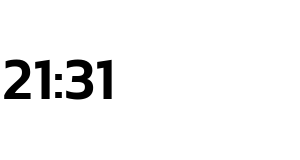

In [170]:
m.active_plugins[0].update()
m.active_plugins[0].image

In [157]:
c = {'plugin': 'xkcd_comicx',
        'base_config': {
            'name': 'XKCD',
            'duration': 200,
            'refresh_interval': 1800,
            'dormant': False,
            'layout': 'layout'
        },
    }
m.add_plugin(c)
m.list_plugins()

2024-12-31 19:19:23,855 [INFO] [__main__] [3537186281.add_plugin] [632] - Validating xkcd_comicx against global schema...
2024-12-31 19:19:23,857 [INFO] [__main__] [3537186281._validate_config] [372] - Config passed schema validation.
2024-12-31 19:19:23,859 [INFO] [__main__] [3537186281._load_plugin_schema] [305] - No plugin-specific schema found for xkcd_comicx. Skipping additional validation.
2024-12-31 19:19:23,861 [INFO] [__main__] [3537186281.add_plugin] [645] - Assigned UUID 693945d4 to new plugin xkcd_comicx.
2024-12-31 19:19:23,863 [WARNING] [__main__] [3537186281.add_plugin] [711] - Failed to load xkcd_comicx: No module named 'plugins.xkcd_comicx'
2024-12-31 19:19:23,865 [INFO] [__main__] [3537186281.list_plugins] [479] - 
--- Configured Plugins ---
2024-12-31 19:19:23,867 [INFO] [__main__] [3537186281.list_plugins] [494] - Name: Basic Clock, UUID: 2801ba41, Status: active, Reason: Loaded successfully
2024-12-31 19:19:23,869 [INFO] [__main__] [3537186281.list_plugins] [494] -

{'active': [{'name': 'Basic Clock',
   'uuid': '2801ba41',
   'status': 'active',
   'reason': 'Loaded successfully'},
  {'name': 'Word Clock',
   'uuid': '6c2c3eb9',
   'status': 'active',
   'reason': 'Loaded successfully'}],
 'dormant': [],
 'load_failed': [{'name': 'XKCD',
   'uuid': '693945d4',
   'status': 'load_failed',
   'reason': "Failed to load xkcd_comicx: No module named 'plugins.xkcd_comicx'"}],
 'unknown': []}

In [158]:
m.remove_plugin('693945d4')

2024-12-31 19:19:33,827 [WARNING] [__main__] [3537186281._remove_plugin_by_uuid] [569] - Plugin with UUID 693945d4 not found in active/dormant lists.
2024-12-31 19:19:33,830 [INFO] [__main__] [3537186281.remove_plugin] [537] - Removed plugin configuration with UUID: 693945d4
2024-12-31 19:19:33,833 [INFO] [__main__] [3537186281.remove_plugin] [544] - Plugin UUID: 693945d4 was not active or dormant.


In [160]:
m.list_plugins()

2024-12-31 19:19:46,712 [INFO] [__main__] [3537186281.list_plugins] [479] - 
--- Configured Plugins ---
2024-12-31 19:19:46,713 [INFO] [__main__] [3537186281.list_plugins] [494] - Name: Basic Clock, UUID: 2801ba41, Status: active, Reason: Loaded successfully
2024-12-31 19:19:46,716 [INFO] [__main__] [3537186281.list_plugins] [494] - Name: Word Clock, UUID: 6c2c3eb9, Status: active, Reason: Loaded successfully


{'active': [{'name': 'Basic Clock',
   'uuid': '2801ba41',
   'status': 'active',
   'reason': 'Loaded successfully'},
  {'name': 'Word Clock',
   'uuid': '6c2c3eb9',
   'status': 'active',
   'reason': 'Loaded successfully'}],
 'dormant': [],
 'load_failed': [],
 'unknown': []}

In [ ]:
import time
from IPython.display import display, clear_output
from PIL import Image

# Toy loop to simulate plugin updates and display images
logger.info("Starting toy loop to simulate plugin updates...")

try:
    while True:
        clear_output(wait=True)  # Clear the output to update display smoothly
        logger.info("\n--- Plugin Update Cycle ---")

        # Update all plugins
        m.update_plugins()

        print('*'*5, m.plugin_failures, '*'*5)
        # Show the currently active plugin and its image (if available)
        if m.foreground_plugin and m.foreground_plugin.image:
            plugin_name = m.foreground_plugin.name
            plugin_data = m.foreground_plugin.data
            image = m.foreground_plugin.image

            logger.info(f"Foreground Plugin: {plugin_name}")
            logger.info(f"Plugin Data: {plugin_data}")
            
            display(image)  # Display the plugin image in Jupyter
        else:
            logger.info("No active plugin at this time.")

        # Simulate a short delay to mimic update intervals
        time.sleep(5)

except KeyboardInterrupt:
    logger.info("Toy loop interrupted. Exiting gracefully.")